In [ ]:
import json
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from statsmodels.tsa.seasonal import seasonal_decompose
import collections
import itertools
import time
import math
from scipy.cluster.hierarchy import fcluster, inconsistent, linkage
from matplotlib import pyplot as plt
import pickle
from sklearn.metrics import silhouette_score
from statsmodels.tsa.api import VAR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/time_dataset.csv'
time_dataset = pd.read_csv(file_path)

# **Hierarchical VAR**

### **1. Preprocessing: Prepare the time-series data for each product, representing the average rating over time (e.g., weekly).**

**Change it to weekly**

In [ ]:
# Change type 'reviewTime' to datetime 'yyyy-mm-dd'
time_dataset['reviewTime'] = pd.to_datetime(time_dataset['reviewTime'], format='%Y-%m-%d')

In [ ]:
# Group by asin and date, then calculate the weekly average rating
df_weekly = time_dataset.groupby(['asin', pd.Grouper(key='reviewTime', freq='W')])['overall'].mean().reset_index()

In [ ]:
# Pivot the DataFrame to have each product's time series in a separate column
df_pivot = df_weekly.pivot(index='reviewTime', columns='asin', values='overall')

In [ ]:
# assuming df is your DataFrame
df_pivot.index = pd.to_datetime(df_pivot.index)  # Ensure index is a datetime
months_in_data = df_pivot.index.to_period('M').nunique()  # Count unique months in data

# Create a list of products that have at least one review every month
products_to_keep = []
for product in df_pivot.columns:
    reviews_by_month = df_pivot[product].resample('M').count()  # count reviews per month
    if (reviews_by_month > 0).sum() == months_in_data:  # if product was reviewed every month
        products_to_keep.append(product)

# Keep only the products that have at least one review every month
df = df_pivot[products_to_keep]
# Apply forward-fill and backward-fill
df_final = df.ffill().bfill()

In [ ]:
asin_list = df.columns.tolist()
filtered_time_dataset = time_dataset[time_dataset['asin'].isin(asin_list)]
category_distribution = filtered_time_dataset.groupby(['asin', 'main_cat']).size()
asin_categories = filtered_time_dataset[['asin', 'main_cat']].drop_duplicates()
asin_categories["main_cat"].value_counts()

Musical Instruments    101
Video Games             48
Appliances              13
Name: main_cat, dtype: int64

In [ ]:
df_var = df_final.copy()

### **2. Hierarchical Clustering: Perform hierarchical clustering within each category to group similar products together based on their time-series patterns**

In [ ]:
!pip install fastdtw
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=471384 sha256=06f637e76853c1b84590daa07c09caf72557eaf49affb5d95b4bad42f2faaed1
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

Processing category: Musical Instruments
Best number of clusters: 2
Best silhouette score: 0.2507834837239817


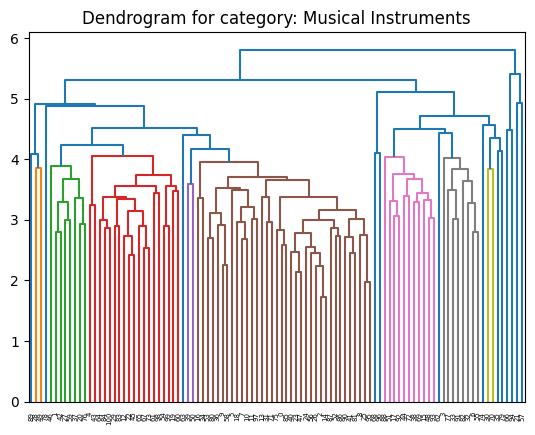

Processing category: Video Games
Best number of clusters: 2
Best silhouette score: 0.13539247013060082


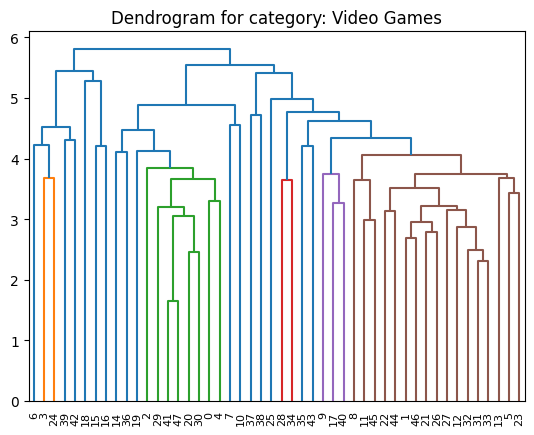

Processing category: Appliances
Best number of clusters: 2
Best silhouette score: 0.3358948510465041


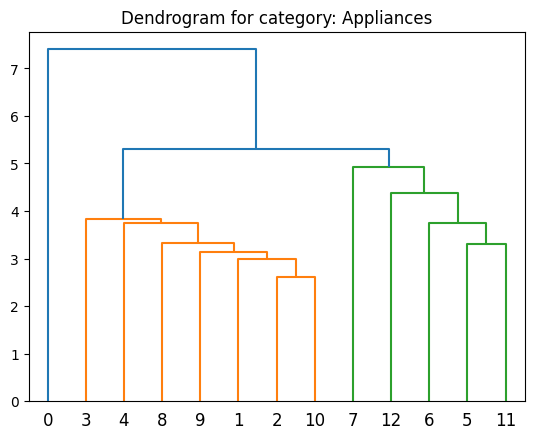

In [ ]:
from scipy.spatial.distance import euclidean

# List of categories
categories = ['Musical Instruments', 'Video Games', 'Appliances']

# Loop through the categories
for cat in categories:
    print(f"Processing category: {cat}")

    # Filter df_var to get data for current category
    df_cat = df_var[asin_categories[asin_categories['main_cat'] == cat]['asin']]


    # Normalize time series
    df_cat = df_cat.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

    # Compute Euclidean distances between time series
    n = len(df_cat.columns)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # Calculate only half matrix
            xi = df_cat.iloc[:, i].dropna()
            xj = df_cat.iloc[:, j].dropna()
            distance = euclidean(xi, xj)
            distances[i, j] = distance
            distances[j, i] = distance  # Force symmetry

    # Compute linkage matrix for hierarchical clustering
    Z = linkage(squareform(distances), method='complete')

    # Find the optimal number of clusters using silhouette score
    best_silhouette = -1
    best_k = 0
    for k in range(2, min(7, n+1)):  # At least two clusters
        clusters = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(distances, clusters, metric='precomputed')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette}")

    # Perform clustering
    clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot the dendrogram
    plt.figure()
    dendrogram(Z)
    plt.title(f"Dendrogram for category: {cat}")
    plt.show()

Processing category: Musical Instruments
Best number of clusters: 2
Best silhouette score: 0.2687557482436037


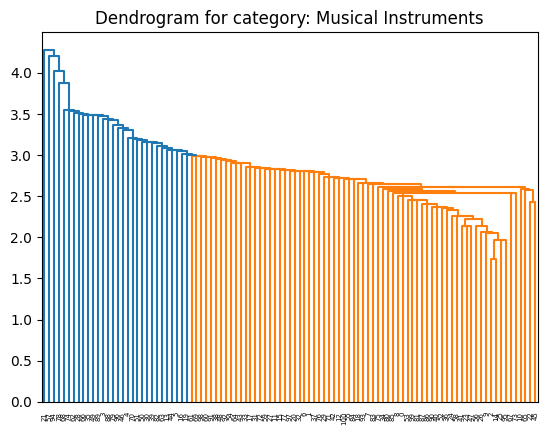

Processing category: Video Games
Best number of clusters: 2
Best silhouette score: 0.129575643189045


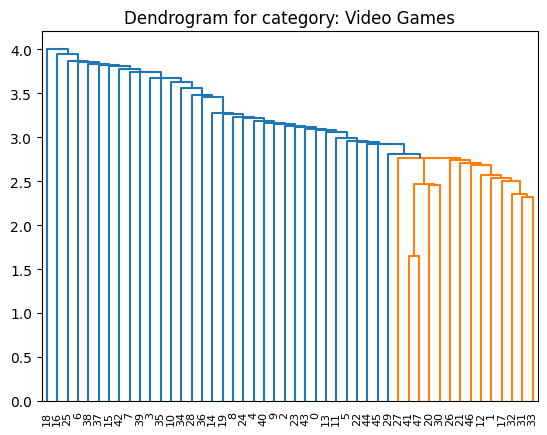

Processing category: Appliances
Best number of clusters: 2
Best silhouette score: 0.3358948510465041


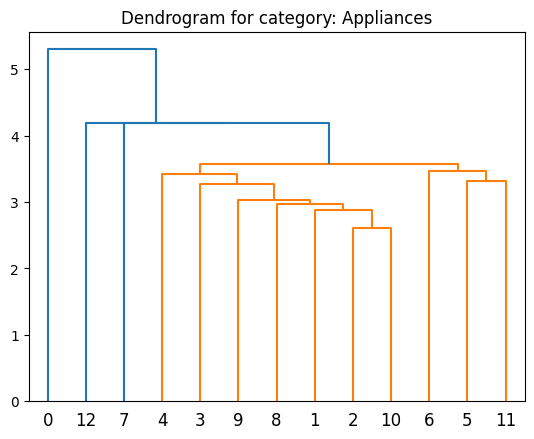

In [ ]:
# List of categories
categories = ['Musical Instruments', 'Video Games', 'Appliances']

# Loop through the categories
for cat in categories:
    print(f"Processing category: {cat}")

    # Filter df_var to get data for current category
    df_cat = df_var[asin_categories[asin_categories['main_cat'] == cat]['asin']]


    # Normalize time series
    df_cat = df_cat.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

    # Compute Euclidean distances between time series
    n = len(df_cat.columns)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # Calculate only half matrix
            xi = df_cat.iloc[:, i].dropna()
            xj = df_cat.iloc[:, j].dropna()
            distance = euclidean(xi, xj)
            distances[i, j] = distance
            distances[j, i] = distance  # Force symmetry

    # Compute linkage matrix for hierarchical clustering
    Z = linkage(squareform(distances), method='single')

    # Find the optimal number of clusters using silhouette score
    best_silhouette = -1
    best_k = 0
    for k in range(2, min(7, n+1)):  # At least two clusters
        clusters = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(distances, clusters, metric='precomputed')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette}")

    # Perform clustering
    clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot the dendrogram
    plt.figure()
    dendrogram(Z)
    plt.title(f"Dendrogram for category: {cat}")
    plt.show()

Processing category: Musical Instruments
Best number of clusters: 2
Best silhouette score: 0.2687557482436037


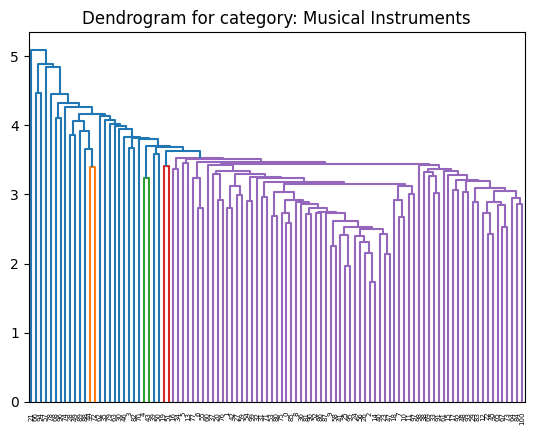

Processing category: Video Games
Best number of clusters: 2
Best silhouette score: 0.129575643189045


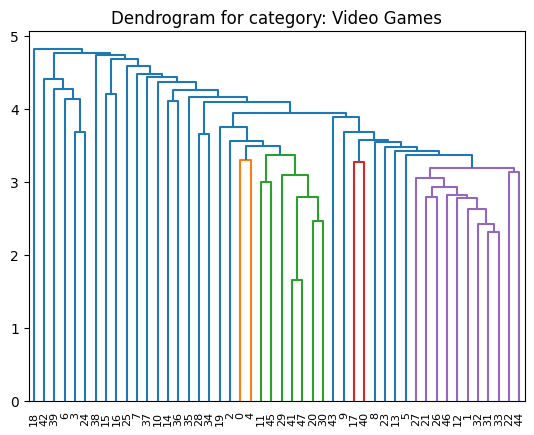

Processing category: Appliances
Best number of clusters: 2
Best silhouette score: 0.3358948510465041


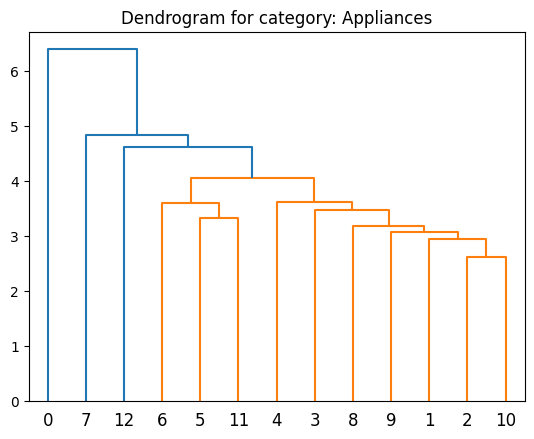

In [ ]:
# List of categories
categories = ['Musical Instruments', 'Video Games', 'Appliances']

# Loop through the categories
for cat in categories:
    print(f"Processing category: {cat}")

    # Filter df_var to get data for current category
    df_cat = df_var[asin_categories[asin_categories['main_cat'] == cat]['asin']]


    # Normalize time series
    df_cat = df_cat.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

    # Compute Euclidean distances between time series
    n = len(df_cat.columns)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # Calculate only half matrix
            xi = df_cat.iloc[:, i].dropna()
            xj = df_cat.iloc[:, j].dropna()
            distance = euclidean(xi, xj)
            distances[i, j] = distance
            distances[j, i] = distance  # Force symmetry

    # Compute linkage matrix for hierarchical clustering
    Z = linkage(squareform(distances), method='average')

    # Find the optimal number of clusters using silhouette score
    best_silhouette = -1
    best_k = 0
    for k in range(2, min(7, n+1)):  # At least two clusters
        clusters = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(distances, clusters, metric='precomputed')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette}")

    # Perform clustering
    clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot the dendrogram
    plt.figure()
    dendrogram(Z)
    plt.title(f"Dendrogram for category: {cat}")
    plt.show()

Processing category: Musical Instruments
Best number of clusters: 2
Best silhouette score: 0.049021118540101806


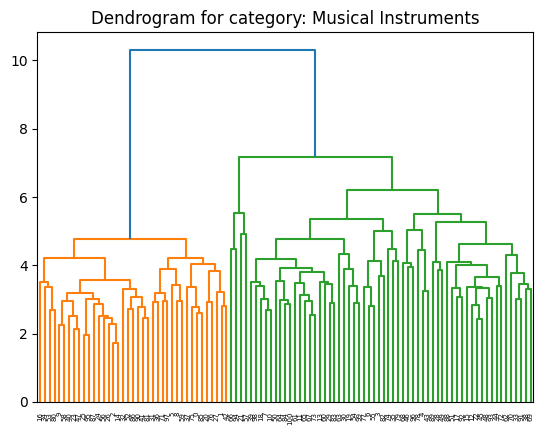

Processing category: Video Games
Best number of clusters: 2
Best silhouette score: 0.09823831192190208


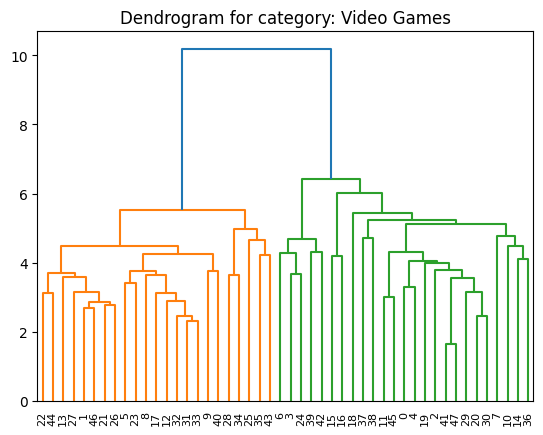

Processing category: Appliances
Best number of clusters: 2
Best silhouette score: 0.3358948510465041


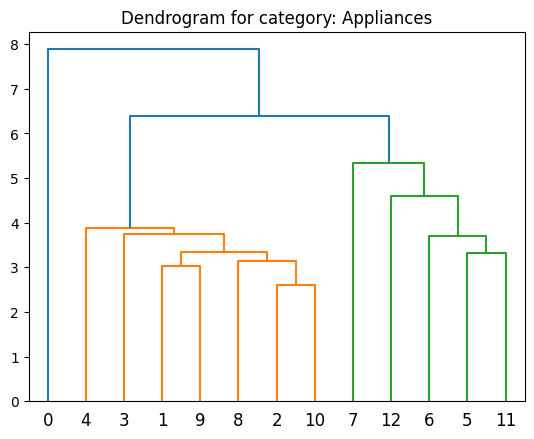

In [ ]:
# List of categories
categories = ['Musical Instruments', 'Video Games', 'Appliances']

# Loop through the categories
for cat in categories:
    print(f"Processing category: {cat}")

    # Filter df_var to get data for current category
    df_cat = df_var[asin_categories[asin_categories['main_cat'] == cat]['asin']]


    # Normalize time series
    df_cat = df_cat.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

    # Compute Euclidean distances between time series
    n = len(df_cat.columns)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # Calculate only half matrix
            xi = df_cat.iloc[:, i].dropna()
            xj = df_cat.iloc[:, j].dropna()
            distance = euclidean(xi, xj)
            distances[i, j] = distance
            distances[j, i] = distance  # Force symmetry

    # Compute linkage matrix for hierarchical clustering
    Z = linkage(squareform(distances), method='ward')

    # Find the optimal number of clusters using silhouette score
    best_silhouette = -1
    best_k = 0
    for k in range(2, min(7, n+1)):  # At least two clusters
        clusters = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(distances, clusters, metric='precomputed')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette}")

    # Perform clustering
    clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot the dendrogram
    plt.figure()
    dendrogram(Z)
    plt.title(f"Dendrogram for category: {cat}")
    plt.show()

Processing category: Musical Instruments
Best number of clusters: 2
Best silhouette score: 0.2723534203325375


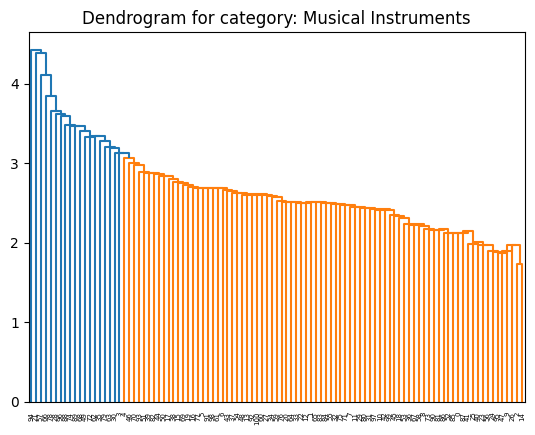

Processing category: Video Games
Best number of clusters: 2
Best silhouette score: 0.14249197120244764


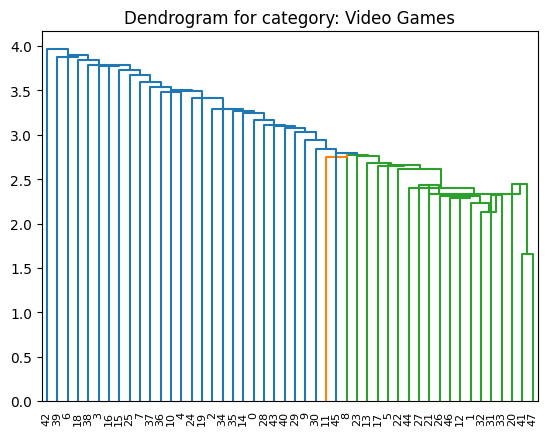

Processing category: Appliances
Best number of clusters: 2
Best silhouette score: 0.3358948510465041


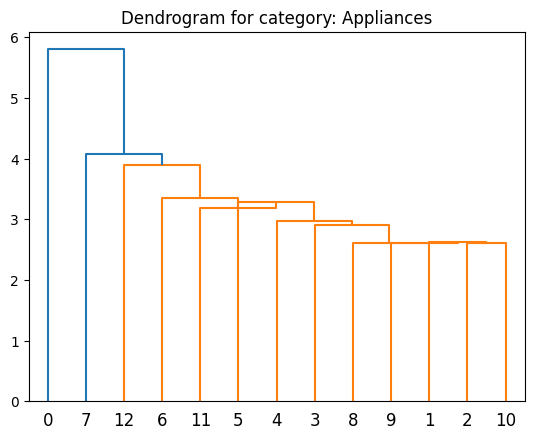

In [ ]:
# List of categories
categories = ['Musical Instruments', 'Video Games', 'Appliances']

# Loop through the categories
for cat in categories:
    print(f"Processing category: {cat}")

    # Filter df_var to get data for current category
    df_cat = df_var[asin_categories[asin_categories['main_cat'] == cat]['asin']]


    # Normalize time series
    df_cat = df_cat.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)))

    # Compute Euclidean distances between time series
    n = len(df_cat.columns)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):  # Calculate only half matrix
            xi = df_cat.iloc[:, i].dropna()
            xj = df_cat.iloc[:, j].dropna()
            distance = euclidean(xi, xj)
            distances[i, j] = distance
            distances[j, i] = distance  # Force symmetry

    # Compute linkage matrix for hierarchical clustering
    Z = linkage(squareform(distances), method='centroid')

    # Find the optimal number of clusters using silhouette score
    best_silhouette = -1
    best_k = 0
    for k in range(2, min(7, n+1)):  # At least two clusters
        clusters = fcluster(Z, k, criterion='maxclust')
        silhouette = silhouette_score(distances, clusters, metric='precomputed')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

    print(f"Best number of clusters: {best_k}")
    print(f"Best silhouette score: {best_silhouette}")

    # Perform clustering
    clusters = fcluster(Z, best_k, criterion='maxclust')

    # Plot the dendrogram
    plt.figure()
    dendrogram(Z)
    plt.title(f"Dendrogram for category: {cat}")
    plt.show()

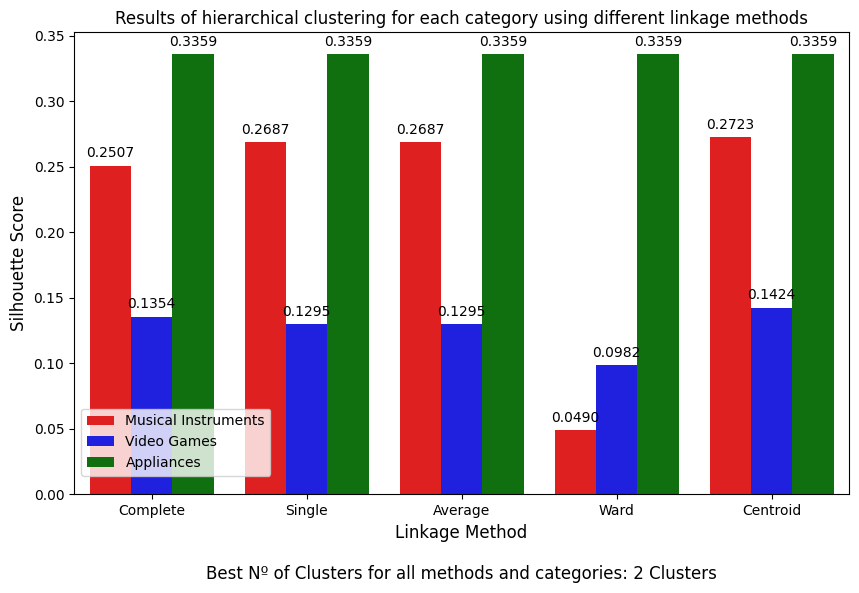

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a DataFrame from the table
data = {
    'Linkage Method': ['Complete', 'Complete', 'Complete', 'Single', 'Single', 'Single', 'Average', 'Average', 'Average', 'Ward', 'Ward', 'Ward', 'Centroid', 'Centroid', 'Centroid'],
    'Category': ['Musical Instruments', 'Video Games', 'Appliances', 'Musical Instruments', 'Video Games', 'Appliances', 'Musical Instruments', 'Video Games', 'Appliances', 'Musical Instruments', 'Video Games', 'Appliances', 'Musical Instruments', 'Video Games', 'Appliances'],
    'Best Nº of Clusters': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
    'Silhouette Score': [0.2507, 0.1354, 0.3359, 0.2687, 0.1295, 0.3359, 0.2687, 0.1295, 0.3359, 0.0490, 0.0982, 0.3359, 0.2723, 0.1424, 0.3359]
}
df = pd.DataFrame(data)

# Define colors for each category
palette = {"Musical Instruments": "red", "Video Games": "blue", "Appliances": "green"}

# Creating the plot
plt.figure(figsize=(10,6))
bar_plot = sns.barplot(x='Linkage Method', y='Silhouette Score', hue='Category', data=df, palette=palette)

# Adding the Silhouette Scores on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.title('Results of hierarchical clustering for each category using different linkage methods')
plt.xlabel('Linkage Method\n\nBest Nº of Clusters for all methods and categories: 2 Clusters', fontsize = 12)
plt.ylabel('Silhouette Score', fontsize = 12)

# Moving the legend to the bottom left
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.2))

plt.show()

### **3. Aggregation: For each cluster, create a single aggregated time series. This could be the average of the ratings for all the products in the cluster.**

In [ ]:
# Define optimal number of clusters for each category
optimal_clusters = {'Video Games': 2, 'Musical Instruments': 2, 'Appliances':2}  # Update with actual values

# A dictionary to hold cluster assignments
cluster_assignments = {}

for category, n_clusters in optimal_clusters.items():
    category_data = df_final[asin_categories[asin_categories['main_cat'] == category]['asin'].unique()]

    linkage_matrix = linkage(category_data.T, 'complete')

    # Assign each product to a cluster
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    cluster_assignments[category] = dict(zip(category_data.columns, cluster_labels))

### **4. VAR Modeling: Fit a VAR model using the aggregated time series of each cluster as a variable. This can be done separately for each category or across all categories. Analyze the results to understand the interdependencies between clusters.**

**Data Preparation**: The first step is to ensure that all variables are stationary, meaning their statistical properties do not change over time. If they are not, they need to be transformed (for example, by differencing) until they are.

**Model Order Selection**: The next step is to choose the lag order for the VAR model. In your case, it seems to be 1, as indicated by the "L1" in front of the variable names.

**Estimation**: The coefficients of the model are then estimated. This is usually done using the method of Ordinary Least Squares (OLS), as indicated in your results.

**Verification**: After the model has been estimated, it's necessary to check for autocorrelation in the residuals, the stability of the model, and the adequacy of the lag length. This can be done using various diagnostic tests.

**Interpretation**: The coefficients of the model are interpreted, paying particular attention to their signs, sizes, and statistical significance.

In [ ]:
import statsmodels.tsa.stattools as ts

# Prepare a DataFrame for the VAR model
var_data = pd.DataFrame(index=df_final.index)

# For each category
max_diffs = 4  # maximum number of differencing steps
for category, assignments in cluster_assignments.items():
    # For each cluster
    for cluster in set(assignments.values()):
        # Identify the products in the cluster
        products_in_cluster = [product for product, assigned_cluster in assignments.items() if assigned_cluster == cluster]
        # Aggregate the time series in the cluster
        cluster_data = df_final[products_in_cluster].mean(axis=1)

        # Check for stationarity
        adf_test = ts.adfuller(cluster_data)
        print(f'ADF Statistic for {category}_cluster_{cluster}: {adf_test[0]}')
        print(f'p-value: {adf_test[1]}')

        num_diffs = 0
        while adf_test[1] > 0.05 and num_diffs < max_diffs:
            # Perform differencing
            cluster_data = cluster_data.diff().dropna()
            # Perform the ADF test on the differenced series
            adf_test = ts.adfuller(cluster_data)
            num_diffs += 1

        if num_diffs == max_diffs:
            print(f"{category}_cluster_{cluster}: data is still non-stationary after {max_diffs} differencing steps")
            print(f'ADF p-value: {adf_test[1]}')
        else:
            print(f"{category}_cluster_{cluster}: data is stationary after {num_diffs} differencing steps")
            print(f'ADF p-value: {adf_test[1]}')

        var_data[f'{category}_cluster_{cluster}_diff_{num_diffs}'] = cluster_data

ADF Statistic for Video Games_cluster_1: -7.6053170889922095
p-value: 2.3306401576843433e-11
Video Games_cluster_1: data is stationary after 0 differencing steps
ADF p-value: 2.3306401576843433e-11
ADF Statistic for Video Games_cluster_2: -4.805031641423441
p-value: 5.319330292836533e-05
Video Games_cluster_2: data is stationary after 0 differencing steps
ADF p-value: 5.319330292836533e-05
ADF Statistic for Musical Instruments_cluster_1: -2.260749106812743
p-value: 0.18493970528168513
Musical Instruments_cluster_1: data is stationary after 1 differencing steps
ADF p-value: 1.3616369963517658e-07
ADF Statistic for Musical Instruments_cluster_2: -5.805758566997662
p-value: 4.5206712638040356e-07
Musical Instruments_cluster_2: data is stationary after 0 differencing steps
ADF p-value: 4.5206712638040356e-07
ADF Statistic for Appliances_cluster_1: -8.518682115748282
p-value: 1.1158988114640527e-13
Appliances_cluster_1: data is stationary after 0 differencing steps
ADF p-value: 1.1158988114

In [ ]:
var_data_1 = var_data.iloc[1:,:]

In [ ]:
# Fit the VAR model
model = VAR(var_data_1)
results = model.fit(maxlags=5, ic='aic')

# Print the results
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Aug, 2023
Time:                     08:28:03
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -10.6552
Nobs:                     107.000    HQIC:                  -11.2790
Log likelihood:          -242.775    FPE:                8.26702e-06
AIC:                     -11.7044    Det(Omega_mle):     5.65226e-06
--------------------------------------------------------------------
Results for equation Video Games_cluster_1_diff_0
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                           2.599050         1.509334            1.722           0.085
L1.Video Games_cluster_1_diff_0         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


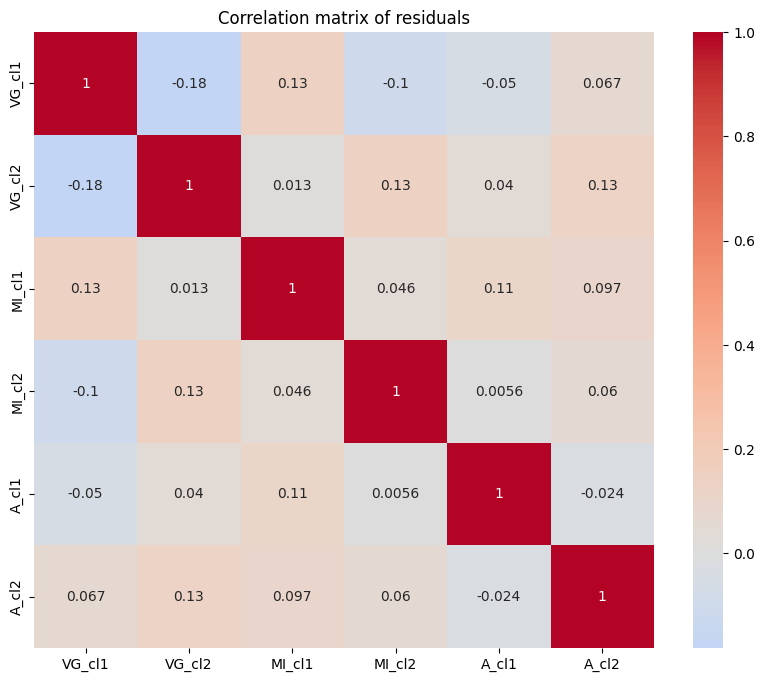

In [ ]:
# Define the correlation matrix
data = {
    'VG_cl1': [1, -0.1820, 0.1320, -0.1007, -0.0504, 0.0674],
    'VG_cl2': [-0.1820, 1, 0.0131, 0.1344, 0.0399, 0.1296],
    'MI_cl1': [0.1320, 0.0131, 1, 0.0457, 0.1056, 0.0971],
    'MI_cl2': [-0.1007, 0.1344, 0.0457, 1, 0.0056, 0.0596],
    'A_cl1': [-0.0504, 0.0399, 0.1056, 0.0056, 1, -0.0243],
    'A_cl2': [0.0674, 0.1296, 0.0971, 0.0596, -0.0243, 1]
}

# Create a DataFrame
df = pd.DataFrame(data, index=['VG_cl1', 'VG_cl2', 'MI_cl1', 'MI_cl2', 'A_cl1', 'A_cl2'])

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix of residuals')
plt.show()

### **5. Validation: Validate the model by checking the prediction accuracy on a hold-out sample.**

This would involve splitting your data into a training and testing set, fitting the VAR model on the training set, and then comparing the model's predictions on the testing set to the actual values.

In [ ]:
from sklearn.model_selection import train_test_split
# Set the random seed
seed = 42
np.random.seed(seed)
# Assuming var_data is your DataFrame and you're holding out 20% for testing
train, test = train_test_split(var_data_1, test_size=0.2, shuffle=False, random_state=seed)

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)
results = model.fit(maxlags=1, ic='aic')  # choose order with AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
# Predict on the testing data
lag_order = results.k_ar
pred = results.forecast(train.values[-lag_order:], steps=len(test))

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# assuming the predictions and true values are both 1-D numpy arrays
mse = mean_squared_error(test, pred)
mae = mean_absolute_error(test, pred)
print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 2)))
print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 2)))

The Mean Squared Error of the forecasts is 0.65
The Mean Absolute Error of the forecasts is 0.54


In [ ]:
# Set the random seed
seed = 42
np.random.seed(seed)
# Assuming var_data is your DataFrame and you're holding out 20% for testing
train_avg, test_avg = train_test_split(df_var, test_size=0.2, shuffle=False, random_state=seed)

# Compute the average product rating per product in the train dataset
avg_product_rating = train_avg.mean()

# Create a DataFrame for average rating predictions
avg_rating_pred = test_avg.copy()
for col in avg_rating_pred.columns:
    if col in avg_product_rating:
        avg_rating_pred[col] = avg_product_rating[col]
    else:
        avg_rating_pred[col] = train_avg.mean().mean() # Use the global mean for any new products

# Flatten the DataFrames for sklearn metrics
test_values = test_avg.values.flatten()
pred_values = avg_rating_pred.values.flatten()

# Calculate the MSE and MAE
mse_baseline = mean_squared_error(test_values, pred_values)
mae_baseline = mean_absolute_error(test_values, pred_values)

print('The Mean Squared Error of the baseline forecasts is {}'.format(round(mse_baseline, 2)))
print('The Mean Absolute Error of the baseline forecasts is {}'.format(round(mae_baseline, 2)))

The Mean Squared Error of the baseline forecasts is 1.16
The Mean Absolute Error of the baseline forecasts is 0.8
